we have all these missing interactions but do know we have members without data and members with data but no interactions so how can we estimate what those members likely read

In [44]:

import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("..")
from network_analysis.load_datasets import get_updated_shxco_data
from network_analysis.generate_network_metrics import *
from network_analysis.create_networks import *
from network_analysis.read_write_networks import *
from network_analysis.visualize_networks import * 


Reading communities? add in additional metadata? can we use that to infer unknown borrowers? use reading/genre 

questioning of not only can we infer missing data but can we also predict what's missing?

1. Drawing outside of the lines and Filling in the Unknowns
   1. sample and far from perfect but have some sense of how exceptional based on the data
    2. useful to think of s&co as a community of people who read the same books (rather than discrete groups)
   1. if we think of it as a network, we can actually explore how much this exceptional behavior skews our existing sample using network stability measures doesn't seem to radically change the overall shape of the network though particular nodes are more stable
   2. one thing we can also do is improving the metadata? books easier than humans 
2. Speculative reading of the past
   1. Identify best community detection for members vs books? igraph, networkx, networkit, and stellargraph. Who was likely to run into who?
   2. use members then books
   3. then use members and book metadata to predict links using link prediction and random forest model
   4. Compare to recommender systems and discuss results
   5. Models vs modes of reading

In [45]:
members_df, books_df, borrow_events, events_df = get_updated_shxco_data(
    get_subscription=False)

unknown_borrows = borrow_events[borrow_events.start_datetime.isna()]
borrow_events = borrow_events[(borrow_events.start_datetime.isna() == False) & (
    borrow_events.end_datetime.isna() == False)]
all_borrows = borrow_events[borrow_events.start_datetime < '1942-01-01'].copy()

unexceptional_borrows = all_borrows[all_borrows.exceptional_types.isna()]

## If you want all events regardless of types, use this:
# all_borrows = events_df[events_df.item_uri.isna() == False].copy()

# unexceptional_borrows = all_borrows[all_borrows.exceptional_types.isna()]


In [46]:
member_attrs = {'uri': 'member_id'}
book_attrs = {'uri': 'item_uri'}
edge_attrs = {'weight': 'counts'}
node_attrs = {}
should_process = True
write_to_file = True
sk_metrics = ['katz', 'louvain']
link_metrics = ['pagerank', 'hubs', 'auth']
is_projected = True
all_borrows_grouped = all_borrows.groupby(
    ['member_id', 'item_uri']).size().reset_index(name='counts')
unexceptional_borrows_grouped = unexceptional_borrows.groupby(
    ['member_id', 'item_uri']).size().reset_index(name='counts')

projected_members_graph, projected_members_nodelist, projected_members_edgelist, projected_members, projected_books_graph, projected_books_nodelist, projected_books_edgelist, projected_books = check_reload_build_unipartite_graphs(
    all_borrows_grouped, all_borrows, member_attrs, book_attrs, edge_attrs, node_attrs, should_process, write_to_file, './data/borrow_events_unipartite_projected', sk_metrics, link_metrics, members_df, books_df, is_projected)



reloading saved graph: ./data/borrow_events_unipartite_projected


In [47]:
nodes_df = pd.DataFrame.from_dict(
    dict(projected_members_graph.nodes(data=True)), orient='index')


In [48]:
label_dict = dict(zip(nodes_df.label, nodes_df.uri))

In [49]:
H = nx.relabel_nodes(projected_members_graph, label_dict)

Networkx Community Detection

In [50]:
subgraph = sorted(
    nx.connected_components(H), key=len, reverse=True)
graph = H.subgraph(subgraph[0])


In [51]:
from networkx.algorithms import community


In [52]:
c = list(community.greedy_modularity_communities(graph))
len(c)

3

In [53]:
community.modularity(graph, c)

0.12610405003168562

In [54]:
import community as community_louvain
partition = community_louvain.best_partition(graph)

In [55]:
partition_df = pd.DataFrame.from_dict(partition, orient='index').reset_index()
partition_df.columns = ['uri', 'community']
partition_df.community.unique().tolist()

[0, 1, 2]

In [56]:
community.partition_quality(graph, c)

(0.5794201714985708, 0.6037430079983271)

In [57]:
comp = community.girvan_newman(graph)
tuple(sorted(c) for c in next(comp))


(['alderman',
  'alvear',
  'antoine-may',
  'arvanon',
  'auger',
  'baker-3',
  'baldwin-helen-green',
  'bazin-de-jessey',
  'beaulieu',
  'beauvoir-simone-de',
  'bernheim',
  'bernheim-antoinette',
  'bernheim-francoise',
  'bertraud-fontaine',
  'bidoire-boulenger',
  'blackmer',
  'blaess',
  'bloch-marguerite-herzog',
  'bonnerot',
  'boscq-marie',
  'bouniols-louise-olga',
  'bourassin-2',
  'bourdet',
  'boyd-james',
  'boyd-madeleine',
  'bremond',
  'brinquant-simone',
  'brull',
  'buratti',
  'burnet-mary-scott',
  'burt-maud',
  'busy',
  'butler-h-m',
  'cahun',
  'camerlynck-guernier',
  'camille-georgette',
  'camp',
  'campbell-arlen',
  'carr-philip',
  'carroll-akrata-von-schrader',
  'cassaigne',
  'catel-jean',
  'cayeux',
  'cayton',
  'cazes',
  'cesaire',
  'chalot',
  'chambaz',
  'chambrillac',
  'chanler',
  'chareau-dorothee',
  'chaudot',
  'chenneviere',
  'child-bertha-cushing',
  'chonez',
  'chopard-2',
  'church-barbara',
  'church-henry',
  'churchi

In [58]:
# nx.simrank_similarity(graph)

In [59]:
from igraph import *


In [60]:
g = Graph.from_networkx(graph)
g

In [61]:
fg_run = g.community_fastgreedy(weights='weight')
clusters = fg_run.as_clustering()
membership = clusters.membership
fg = pd.DataFrame().from_dict(
    dict(zip(g.vs['uri'], membership)), orient='index').reset_index()
fg.columns = ['uri', 'community']
fg.community.unique().tolist()


[0, 1, 2, 3]

In [62]:
im_run = g.community_infomap(edge_weights='weight')
membership = im_run.membership
im = pd.DataFrame().from_dict(dict(zip(g.vs['uri'], membership)), orient='index').reset_index()
im.columns = ['uri', 'community']
im.community.unique().tolist()

[0]

In [63]:
ei_run = g.community_leading_eigenvector(weights='weight')
membership = ei_run.membership
ei = pd.DataFrame().from_dict(dict(zip(g.vs['uri'], membership)), orient='index').reset_index()
ei.columns = ['uri', 'community']
ei.community.unique().tolist()

[0, 1, 2]

In [64]:
si_run = g.community_spinglass(weights='weight')
membership = si_run.membership

In [65]:
si = pd.DataFrame().from_dict(dict(zip(g.vs['uri'], membership)), orient='index').reset_index()
si.columns = ['uri', 'community']
si.community.unique().tolist()

[1, 4, 0, 3, 2, 5]

In [67]:
im_run = g.community_infomap()

In [69]:
len(graph.nodes())

518

In [70]:
graph_ints = nx.convert_node_labels_to_integers(graph)
len(graph_ints.nodes())

518

In [81]:
import karateclub as kc
model = kc.MNMF()
model.fit(graph_ints)
cluster_membership = model.get_memberships()


In [82]:
label_df = pd.DataFrame.from_dict(dict(cluster_membership), orient='index').reset_index()
label_df.columns = ['uri', 'community']
label_df.groupby('community').size().sort_values(ascending=False)

community
5    154
3    111
7     87
2     28
9     27
0     23
1     23
4     23
6     21
8     21
dtype: int64

In [86]:
model = kc.GraphWave()
model.fit(graph_ints)
cluster_embedding = model.get_embedding()

2021-12-17 18:27:07,265:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [89]:
cluster_embedding.shape[1]

400

In [90]:
from sklearn.manifold import TSNE


In [91]:
transformed_embedding = TSNE(n_components=2).fit_transform(cluster_embedding)

In [92]:
import matplotlib.pyplot as plt

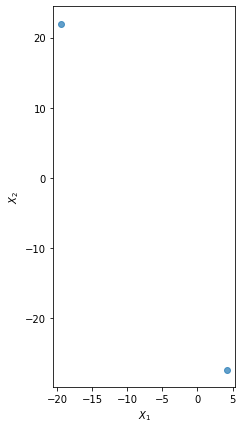

In [93]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(transformed_embedding[0], transformed_embedding[1], alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
# plt.title("{} visualization of GraphSAGE embeddings".format(transform.__name__))
plt.show()
